In [1]:
!nvidia-smi -L

GPU 0: NVIDIA A100-SXM4-80GB (UUID: GPU-6620e1a6-0d7f-6cfe-1290-c3b795ee422b)
GPU 1: NVIDIA A100-SXM4-80GB (UUID: GPU-e84e0c4d-caeb-bff4-5bc2-79000e81f2c0)
GPU 2: NVIDIA A100-SXM4-80GB (UUID: GPU-dc94ed04-30d2-926e-e48b-c5871da3a409)
GPU 3: NVIDIA A100-SXM4-80GB (UUID: GPU-6b944573-903d-4082-ca47-887921f8e7ca)
GPU 4: NVIDIA A100-SXM4-80GB (UUID: GPU-e7845ea0-c487-e96f-5fda-ebb1f6f84bc5)
  MIG 7g.80gb     Device  0: (UUID: MIG-96f30d00-fc64-5fd0-88b0-6332787d91c5)
GPU 5: NVIDIA A100-SXM4-80GB (UUID: GPU-85f6cf92-7790-c646-0e14-f10401fe214b)
GPU 6: NVIDIA A100-SXM4-80GB (UUID: GPU-e0c3d35e-579b-c1d6-eea9-c7691d42f275)
GPU 7: NVIDIA A100-SXM4-80GB (UUID: GPU-901a28b5-9684-0cc5-cec6-d78b14cfe130)


In [2]:
!pip install transformers datasets evaluate

# clean up the output
from IPython.display import clear_output
clear_output()

In [4]:
from datasets import load_dataset
from transformers import AutoFeatureExtractor, AutoModelForImageClassification, TrainingArguments, Trainer
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

# Load the dataset
dataset = load_dataset("beans")

dataset

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

In [1]:
labels = dataset["train"].features["labels"].names


label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

NameError: name 'dataset' is not defined

In [6]:
labels 

['angular_leaf_spot', 'bean_rust', 'healthy']

In [7]:
label2id,

({'angular_leaf_spot': '0', 'bean_rust': '1', 'healthy': '2'},)

In [8]:
id2label

{'0': 'angular_leaf_spot', '1': 'bean_rust', '2': 'healthy'}

In [9]:


# Load the pre-trained model and feature extractor
model_name = "google/vit-base-patch16-224-in21k"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
model = AutoModelForImageClassification.from_pretrained(model_name,  num_labels=len(labels))

model


/home/tuchsanai/.conda/envs/torch/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [10]:
model 

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

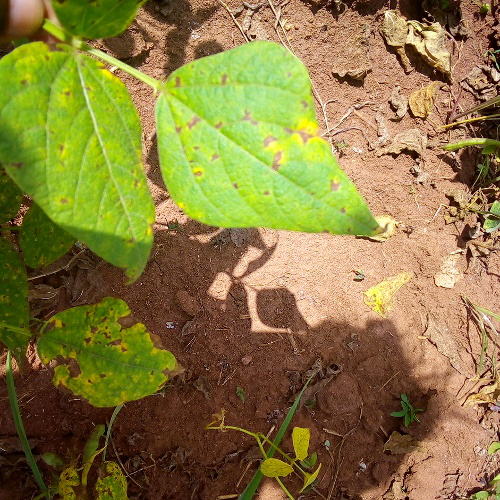

In [11]:
dataset['train'][0]['image']

In [12]:
dataset['train'][0]['labels']

0

In [13]:

# Define the image augmentation transforms
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])

# Preprocess the dataset with image augmentation
def preprocess_function(examples):
    inputs = {}
    inputs["pixel_values"] = [train_transforms(image.convert("RGB")) for image in examples["image"]]
    inputs["labels"] = examples["labels"]
    return inputs

def preprocess_function_val(examples):
    inputs = {}
    inputs["pixel_values"] = [val_transforms(image.convert("RGB")) for image in examples["image"]]
    inputs["labels"] = examples["labels"]
    return inputs

processed_dataset = dataset.map(preprocess_function, batched=True, remove_columns=dataset["train"].column_names)
processed_dataset["validation"] = dataset["validation"].map(preprocess_function_val, batched=True, remove_columns=dataset["validation"].column_names)

# Display

In [17]:
processed_dataset 

DatasetDict({
    train: Dataset({
        features: ['labels', 'pixel_values'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['labels', 'pixel_values'],
        num_rows: 133
    })
    test: Dataset({
        features: ['labels', 'pixel_values'],
        num_rows: 128
    })
})

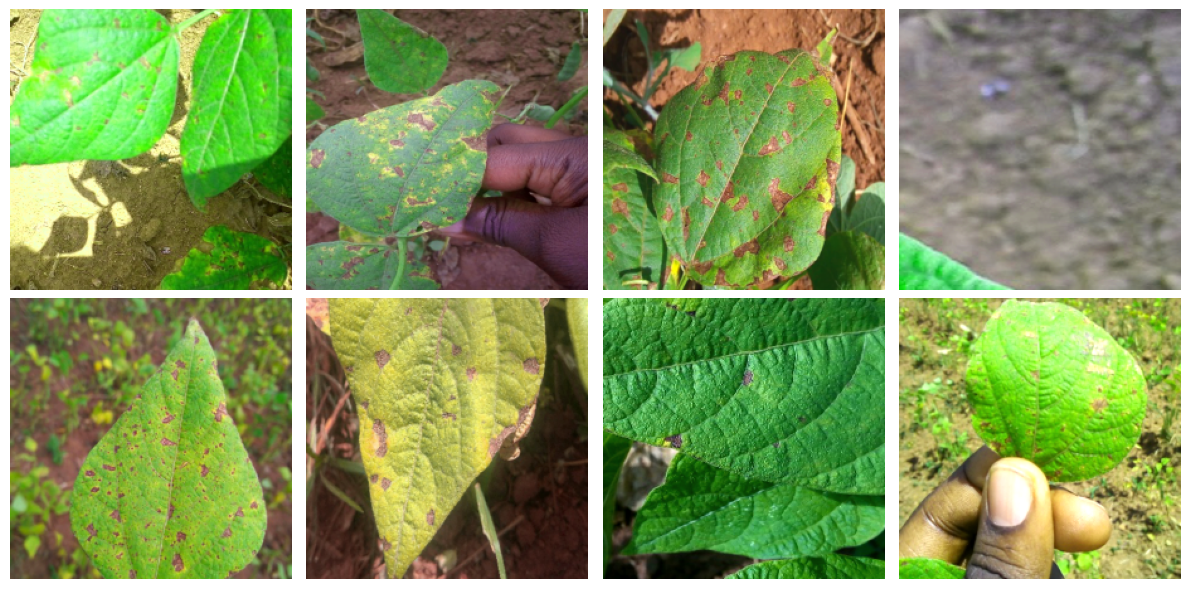

In [14]:
# Display some augmented images
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
for i in range(2):
    for j in range(4):
        image = processed_dataset["train"][i*4+j]["pixel_values"]
        image = torch.tensor(image)  # Convert the list to a tensor
        image = image.permute(1, 2, 0).numpy()
        image = (image - image.min()) / (image.max() - image.min())  # Normalize pixel values to [0, 1]
        axs[i, j].imshow(image)
        axs[i, j].axis("off")
plt.tight_layout()
plt.show()

In [ ]:
import psutil
import torch
from transformers import Trainer
from transformers import TrainerCallback


def get_cpu_gpu_usage():
    cpu_usage = psutil.cpu_percent()
    gpu_usage = torch.cuda.utilization() if torch.cuda.is_available() else None
    return cpu_usage, gpu_usage


class MonitoringCallback(TrainerCallback):
    def __init__(self):
        self.cpu_gpu_usage = []

    def on_step_end(self, args, state, control, **kwargs):
        cpu_usage, gpu_usage = get_cpu_gpu_usage()
        self.cpu_gpu_usage.append((cpu_usage, gpu_usage))

In [16]:

# Define the data collator
def collate_fn(examples):
    pixel_values = torch.stack([torch.tensor(example["pixel_values"]) for example in examples])
    labels = torch.tensor([example["labels"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

# Define the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=96,
    evaluation_strategy="steps",
    num_train_epochs=5,
    #fp16=True,
    save_steps=100,
    eval_steps=100,
    logging_steps=10,
    learning_rate=2e-5,
    save_total_limit=2,
    remove_unused_columns=False,
    metric_for_best_model="accuracy",
)

# Create the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["validation"],
    tokenizer=feature_extractor,
    data_collator=collate_fn,
    callbacks=[GPUMonitorCallback],
)

# Train the model
trainer.train()

/home/tuchsanai/.conda/envs/torch/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


RuntimeError: TensorBoardCallback requires tensorboard to be installed. Either update your PyTorch version or install tensorboardX.